# DTSA-5511 Week 5 Programming Assignment

This assignment explores Generative Aderversarial Network (GAN) techniques to produce synthetic Monet-esque images. The training dataset, which is a collection of 300 256X256 Monet jpegs, came from the [I’m Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started/overview) competition on Kaggle.

I built two GAN pipelines and experimented with a number of hyperparameters until I got semi-Monet-like results. The code in this notebook borrows heavily from the [Monet CycleGAN Tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) created by Amy Jang, and the [DCGAN to generate face images](https://keras.io/examples/generative/dcgan_overriding_train_step/) tutorial from François Chollet.

I used a [Goolge Colab](https://colab.research.google.com/drive/1iL_S0OGGUn69x29SaOBSRPZZ56xTnURV?usp=sharing) environment connected to an NVIDIA A100 GPU to run the GAN training and inference. 


### GAN operation
In this project, we start with 300 real Monet images. We have two neural networks - a “generator” (or “art forger”) and “discriminator” (or “art critic”). At the start, we use the untrained generator to create 64 fake Monet images (these are just noise at first), and we take 64 real Monet images totalling 128 images. We do a forward pass of these labeled images through the discriminator, and from the loss we update the discriminator's weights using backpropagation. Then we "freeze" the discriminator's weights, and we run another forward pass with a new set of 64 random noise inputs put through the generator, but this time we have deceptively labeled the images as "real" rather than fake. We measure the error in the discriminator's assessment of each of these fake images. Where the discriminator succeeds in classifying the images as fake, we treat this as an error for the generator, and we update the generator's weights against this loss. Then this process repeats for each batch of 64+64 images, and through many epochs, the generator eventually gets good at forging to the point that the discriminator cannot tell the difference between real and fake images.

## Import Kaggle Data

In [1]:
from google.colab import files

In [ ]:
files.upload()

In [3]:
!pwd

/content


In [4]:
!mkdir -p /root/.config/kaggle

In [5]:
!mv kaggle.json /root/.config/kaggle/

In [6]:
!chmod 600 /root/.config/kaggle/kaggle.json

In [7]:
!kaggle competitions download -c gan-getting-started

 84% 308M/367M [00:00<00:00, 1.61GB/s]
100% 367M/367M [00:00<00:00, 1.61GB/s]


In [8]:
!unzip -q gan-getting-started.zip

## Setup Compute Environment

In [9]:
%pip install -q tensorflow

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import random
import os
from PIL import Image

import matplotlib.image as mpimg
import matplotlib.pyplot as plt


The code below is taken from the [Monet CycleGAN Tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook). It is for detecting if there is a GPU or TPU available for acceleration of matrix math operations. I tried running the training on a v6e-1 TPU in Colab, but I found the NVIDIA A100 GPU was faster. So, this code only had the effect of connecting to the single A100 GPU.

In [11]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

Number of replicas: 1
2.19.0


In [12]:
MONET_FILEPATH = os.path.join('monet_tfrec')

In [13]:
MONET_FILENAMES = os.listdir(MONET_FILEPATH)

## Data Preparation

Also from the [Monet CycleGAN Tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) tutorial, this code imports the 8-bit binary image data from the TFRecord format into a `TFRecordDataset` object with all images indexed in batches ready for training. The `decode_image` function transforms each image into a 256X256X3 tensor (3 channels for RGB) and also normalizes the intensity to between 0 and 2 (the intensity of each red, green, or blue pixel in its raw form is an integer between 0 and 255, 255/2 is 127.5) before subtracting 1 to center the distribution of image intensities at 0. So the elements in the 256X256X3 tensor are distributed between -1 and 1.

I chose to initially work with 256X256 image size and batch size of 64 for training the first GAN pipeline.

In [ ]:
IMAGE_SIZE_1 = [256, 256]
BATCH_SIZE = 64

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE_1, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [ ]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset([os.path.join(MONET_FILEPATH, filename) for filename in filenames])
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [ ]:
monet_ds_1 = load_dataset(MONET_FILENAMES, labeled=True).batch(BATCH_SIZE)

In [ ]:
example_monet = next(iter(monet_ds_1))

## EDA

Below we see an example of a real Monet painting from the data set. Before display, we need to take the pixel intensities, which from the previous step are distributed between -1 and 1, multiply them by 0.5, and then add 0.5 to result in an intensity range between 0 and 1 for plotting in matplotlib.

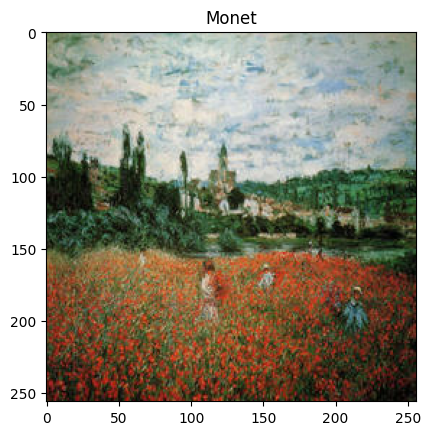

In [ ]:
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

Five examples giving a glimpse into the variety of imagery and colors in Monet's work. All of these show the distinct impressionistic brushwork and textures Monet is famous for.

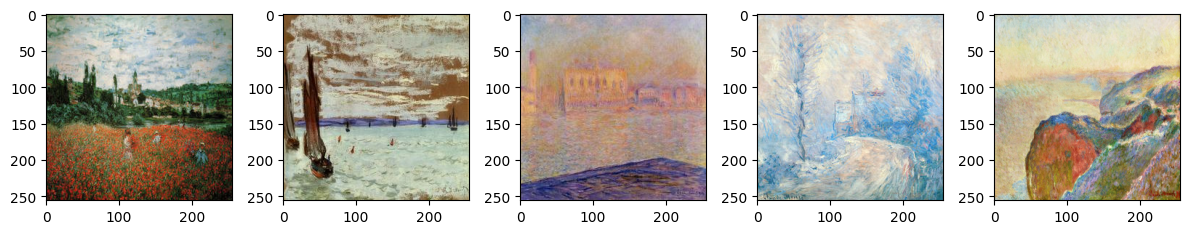

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(12,4))

batch = next(iter(monet_ds_1))

for i in range(5):
    axes[i].imshow(batch[i] * 0.5 + 0.5)

plt.tight_layout()
plt.show()

## Model Building

### DCGAN Attempt #1

We'll start building the first discriminator using a DCGAN (deep convolutional GAN) architecture progressively dividing the original image dimensions by 2 and adding deeper and deeper channels to arrive at an 8X8X1024 feature map flattened into a densely connected single node output. We use Leaky ReLU activation functions throughout the network, which helps prevent gradients from vanishing during training by allowing a small, non-zero gradient to flow even when a unit's input is negative. Batch normalization is used after the convolutional layers to stabilize the gradients.

In [ ]:
discriminator_1 = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(1024, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1),
    ],
    name="discriminator_1",
)

discriminator_1.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 1024)     │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        65,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,219,393 (42.80 MB)

 Trainable params: 11,215,553 (42.78 MB)

 Non-trainable params: 3,840 (15.00 KB)

Our first generator will be an inverted CNN using `Conv2DTranspose` layers to upsample from an initial 4x4x1024 tensor all the way up to the final 256x256x3 image. The final layer is a standard `Conv2D` layer which outputs the 3-channel RGB image, and its `tanh` activation function scales the output to the range [-1, 1] to match the normalization of the real images. Leaky ReLU activations are again used to protect the gradient from ever reaching 0. Batch normalization is also used to stablize the training from one layer to the next.

In [ ]:
latent_dim = 128

generator_1 = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(4 * 4 * 1024),
        layers.Reshape((4, 4, 1024)),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(16, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
    ],
    name="generator_1",
)

generator_1.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 16384)          │     2,113,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 512)      │     8,389,120 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 32)   │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 256, 256, 16)   │         8,208 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │             

 Total params: 13,301,859 (50.74 MB)

 Trainable params: 13,299,843 (50.73 MB)

 Non-trainable params: 2,016 (7.88 KB)

The `DCGAN` class is taken directly from the [DCGAN to generate face images](https://keras.io/examples/generative/dcgan_overriding_train_step/) tutorial. It provides a clean way to manage the GAN by subclassing `keras.Model` and overriding the `train_step` method. This custom training loop allows us to define the process of first training the discriminator on both real and fake images, and then training the generator to produce images that fool the discriminator.

In [14]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # 1. Train the discriminator
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels (label smoothing)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # 2. Train the generator
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors)
            )
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
os.mkdir('generated_images_1')

In [ ]:
IMAGE_DIR = 'generated_images_1'

The `GANMonitor` class, also from [DCGAN to generate face images](https://keras.io/examples/generative/dcgan_overriding_train_step/), is a callback that saves a sample of generated images at the end of each epoch. By using a fixed set of vectors as the seed at the end of each epoch, it gives us a stable reference for monitoring how the generator's output changes over the course of the training.

In [15]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, img_dir, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.img_dir = img_dir
        # Use a fixed seed to see how the same latent vectors evolve
        self.seed = tf.random.normal([self.num_img, self.latent_dim])


    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        # Un-normalize the images from [-1, 1] to [0, 255]
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            # Use os.path.join for platform-independent path construction
            img_path = os.path.join(self.img_dir, f"generated_img_epoch-{epoch+1}_img-{i}.png")
            img.save(img_path)

The first DCGAN is trained for 100 epochs using the Adam optimizer with the same learning rate for both the generator and discriminator. For the loss function, we use `BinaryCrossentropy` with `from_logits=True`. This tells the loss function that the discriminator's final output is handled as a raw logit value, not a probability. This prevents the loss function from having to calculate log(p) where the output could be very small (approaching 0) or large (approaching infinity) - leading to numerical instability.

In [ ]:
epochs = 100

# Create an instance of the DCGAN class
gan_1 = DCGAN(discriminator=discriminator_1, generator=generator_1, latent_dim=latent_dim)

# Compile the model with optimizers and the correct loss function
gan_1.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# Create an instance of the callback to monitor training
gan_monitor = GANMonitor(IMAGE_DIR, num_img=10, latent_dim=latent_dim)

gan_1.fit(
    monet_ds_1,
    epochs=epochs,
    callbacks=[gan_monitor]
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - d_loss: 0.5632 - g_loss: 0.6868
Epoch 2/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - d_loss: 0.2821 - g_loss: 1.7245
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - d_loss: 0.0634 - g_loss: 9.9848
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - d_loss: 0.7129 - g_loss: 40.9267
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - d_loss: 1.0523 - g_loss: 2.3297
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - d_loss: 0.1707 - g_loss: 5.5880
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - d_loss: 0.2138 - g_loss: 5.4390
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - d_loss: 0.1054 - g_loss: 6.6146
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - d_loss: 0.1132 - g_loss: 5.6994
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - d_loss: 0.0496 - g_loss: 7.5011
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - d_loss: 0.0717 - g_loss: 10.0496
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - d_loss: 0.6893 - g_loss: 19.1856
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - d_loss: 0.4922 - g_loss: 10.7646
Epoch 14/100
5/5 ━━━

## Results from first DCGAN attempt

The initial training at 256x256 resolution turned out to produce images that were completely un-Monet-like. Below is the last image produced in the final epoch from the first DCGAN. The uniform, grid-like nature of the image suggests the model is suffering from [mode collapse](https://en.wikipedia.org/wiki/Mode_collapse). This is when the generator finds a "formula" that consistently fools the discriminator, and the generator stops learning.

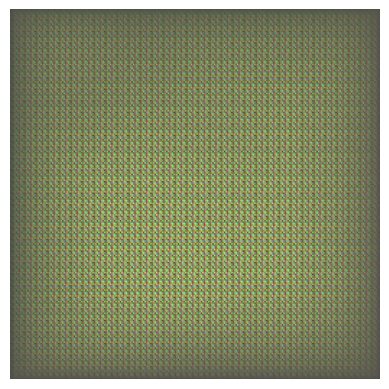

generated_img_epoch-9_img-9.png


In [ ]:
generated_images_1_list = os.listdir('generated_images_1')
generated_images_1_list.sort()
last_image = generated_images_1_list[-1]

img = mpimg.imread(os.path.join(IMAGE_DIR, last_image))
plt.imshow(img)
plt.axis('off')
plt.show()

print(last_image)


Looking at random images produced throughougt the epochs, we can see some nondistinct patterns emerge, but nothing that looks remotely like a Monet painting. This suggests that either 100 epochs is not enough to train this DCGAN architecture to generate 256X256 images, or there is an imbalance in the hyperparamters that is causing the training to fail.

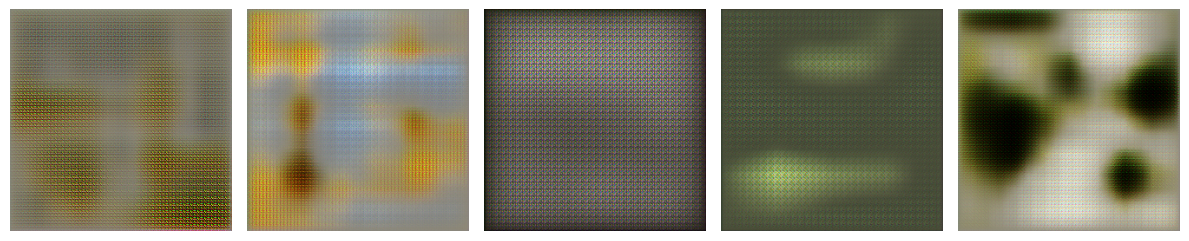

In [ ]:
generated_images_1_list_random_indices = random.sample(range(len(generated_images_1_list)), 5)

fig, axes = plt.subplots(1, 5, figsize=(12,4))

generated_images_1_list_batch = [generated_images_1_list[i] for i in generated_images_1_list_random_indices]

for i, image_filename in enumerate(generated_images_1_list_batch):
    image_path = os.path.join('generated_images_1', image_filename)
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### DCGAN Attempt #2

To address these shortcomings, I made several changes in the second DCGAN architecture and hyperparamters. I reduced the image resolution to 128x128 while also increasing the epochs to 500 (rather than 100). The training time with these new settings was about the same as 256X256 at 100 epochs (using the A100 GPU). Additionally, for the second DCGAN I set different learning rates for the generator and discriminator, slowing down the discriminator to give the generator a better chance to learn how to paint like Monet without being stilted by a "too sharp" discriminator. These adjustments resulted in a much more stable training process and higher-quality final images.

In [16]:
IMAGE_SIZE_2 = [128, 128]
BATCH_SIZE = 64

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.image.resize(image, IMAGE_SIZE_2) # Pass only IMAGE_SIZE_2
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [17]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset([os.path.join(MONET_FILEPATH, filename) for filename in filenames])
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [18]:
monet_ds_2 = load_dataset(MONET_FILENAMES, labeled=True).batch(BATCH_SIZE)

In [19]:
discriminator_2 = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1),
    ],
    name="discriminator_2",
)

discriminator_2.summary()

Model: "discriminator_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 512)      │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,792,897 (10.65 MB)

 Trainable params: 2,791,105 (10.65 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [20]:
latent_dim = 128

generator_2 = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(4 * 4 * 1024),
        layers.Reshape((4, 4, 1024)),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
    ],
    name="generator_2",
)

generator_2.summary()

Model: "generator_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 16384)          │     2,113,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 512)      │     8,389,120 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 32)   │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 3)    │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,294,787 (50.72 MB)

 Trainable params: 13,292,803 (50.71 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [26]:
os.mkdir('generated_images_2')

In [27]:
IMAGE_DIR = 'generated_images_2'

In [28]:
epochs = 500

# Create an instance of the DCGAN class
gan_2 = DCGAN(discriminator=discriminator_2, generator=generator_2, latent_dim=latent_dim)

# Compile the model with optimizers and the correct loss function
gan_2.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# Create an instance of the callback to monitor training
gan_monitor_2 = GANMonitor(IMAGE_DIR, num_img=10, latent_dim=latent_dim)

# Start training! (Pass your prepared monet_ds here)
gan_2.fit(
    monet_ds_2,
    epochs=epochs,
    callbacks=[gan_monitor_2]
)

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - d_loss: 0.2887 - g_loss: 2.3502
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - d_loss: 0.3403 - g_loss: 2.1312
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - d_loss: 0.3810 - g_loss: 2.0665
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - d_loss: 0.3842 - g_loss: 2.3089
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - d_loss: 0.4083 - g_loss: 2.2479
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - d_loss: 0.3803 - g_loss: 2.2845
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - d_loss: 0.3669 - g_loss: 2.2553
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - d_loss: 0.3725 - g_loss: 2.0766
Epoch 9/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - d_loss: 0.4100 - g_loss: 2.2056
Epoch 10/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - d_loss: 0.4623 - g_loss: 2.1157
Epoch 11/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - d_loss: 0.4655 - g_loss: 2.1390
Epoch 12/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - d_loss: 0.4519 - g_los

## Results from second DCGAN attempt

The below image is the final one saved in the last epoch while training DCGAN #2. This looks more like a Monet! Theres is a hint of square "chunking" across the face of the image (possibly due to the stride of the generator's upsampling kernels or the tensorflow resizing algorithm that I used to convert from 128X128 to 256X256). Nonetheless, the blured, nature-inspired colors are reminiscent of Monet-style paintings.

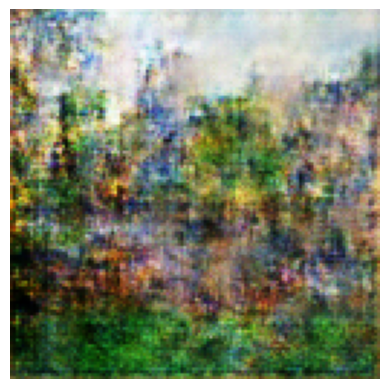

generated_img_epoch-9_img-9.png


In [ ]:
generated_images_2_list = os.listdir('generated_images_2')
generated_images_2_list.sort()
last_image = generated_images_2_list[-1]

img = mpimg.imread(os.path.join(IMAGE_DIR, last_image))
plt.imshow(img)
plt.axis('off')
plt.show()

print(last_image)

Looking at random samples from the different epochs in the DCGAN #2 training, some of these look quite Monet-inspired. The first and third from the left look almost like there is a reflection in water, which is a distinct hallmark of Monet paintings (like in the famous waterlillies paintings).

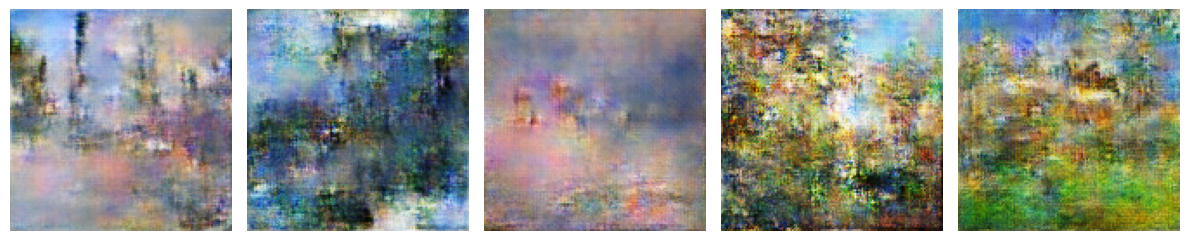

In [30]:
generated_images_2_list_random_indices = random.sample(range(len(generated_images_2_list)), 5)

fig, axes = plt.subplots(1, 5, figsize=(12,4))

generated_images_2_list_batch = [generated_images_2_list[i] for i in generated_images_2_list_random_indices]

for i, image_filename in enumerate(generated_images_2_list_batch):
    image_path = os.path.join('generated_images_2', image_filename)
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Generate Kaggle submission files

In [34]:
# Create 7000 randomized 128X128 vectors
latent_vectors = tf.random.normal(shape=(7000, latent_dim))

# Generate images in batches of 100
batch_size_gen = 100
generated_128_images_list = []

for i in range(0, 7000, batch_size_gen):
    latent_batch = latent_vectors[i:i + batch_size_gen]
    generated_batch = gan_2.generator(latent_batch)
    generated_128_images_list.append(generated_batch)

generated_128_images = tf.concat(generated_128_images_list, axis=0)

# Upscale the batch of 128x128 images to 256x256
generated_256_images = tf.image.resize(generated_128_images, [256, 256])

# Un-normalize and save the 256x256 images
generated_256_images = (generated_256_images * 127.5) + 127.5

In [ ]:
images_dir = 'images'
os.makedirs(images_dir, exist_ok=True)

for i, img_tensor in enumerate(generated_256_images):
    # Convert the TensorFlow tensor to a PIL Image
    img = keras.utils.array_to_img(img_tensor)

    img_path = os.path.join(images_dir, f"generated_image_{i+1}.jpg")
    img.save(img_path, 'JPEG')

print(f"Saved {len(generated_256_images)} images to '{images_dir}'")

zip_filename = 'images.zip'
!zip -r {zip_filename} {images_dir}

print(f"Created zip file: '{zip_filename}'")

## Conclusion

In this project, I demonstrated the process of building and training DCGAN models to produce images in the style of Monet. By adjusting the model architecture, image resolution, and learning rates, I was able to fix problems with mode collapse, and I arrived at some fairly descent results. 

I made several attempts at submitting the final generated images (7000 images produced by the generator model, stored in an images.zip file) to the Kaggle competition. Unfortunately, I kept on getting a generic error in the UI every time I tried to submit, so I chose to put that aside.

To further improve the DCGAN model, the most direct next step would be to train for more epochs. With a GPU or TPU, this should be feasible. For the highest quality, one could try training a DCGAN for full 256x256 resolution. Additional tuning with different learning rate schedules or adjusting the network's capacity (number of filters), could also yield higher-fidelity images.